Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
Review criteria

Придерживайтесь стандартного алгоритма построения прогноза:

    Визуальный анализ ряда
    Стабилизация дисперсии (при необходимости)
    Выбор порядка дифференцирования
    Выбор начальных приближений для p,q,P,Q
    Обучение и сравнение моделей-кандидатов, выбор победителя
    Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
    Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

# Загружаем исходные данные

In [21]:
%matplotlib inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import numpy as np

In [3]:
wage = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [5]:
wage.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


# Первый взгляд на данные

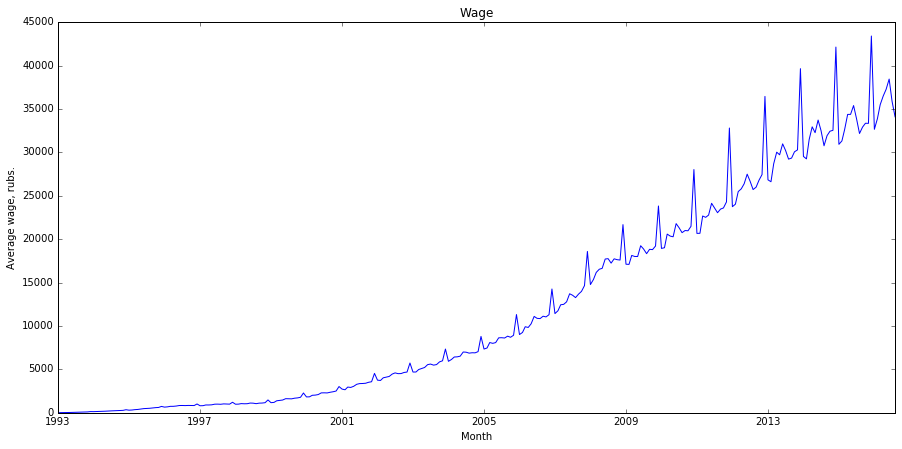

In [6]:
plt.figure(figsize = (15, 7))
plt.plot(wage)
plt.title('Wage')
plt.xlabel('Month')
plt.ylabel('Average wage, rubs.')

По графику исследуемого показателя можно сделать следующие предварительные выводы:
1. Присутствует ярко выраженный тренд на повышение;
2. Присутствует сезонность;
3. Дисперсия показателя увеличивается со временем.
Из этого можно сделать вывод о том, что исходный ряд нестационарен.

# Стабилизация дисперсии

С помощью преобразования Бокса-Кокса стабилизируем дисперсию ряда.

In [7]:
# обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


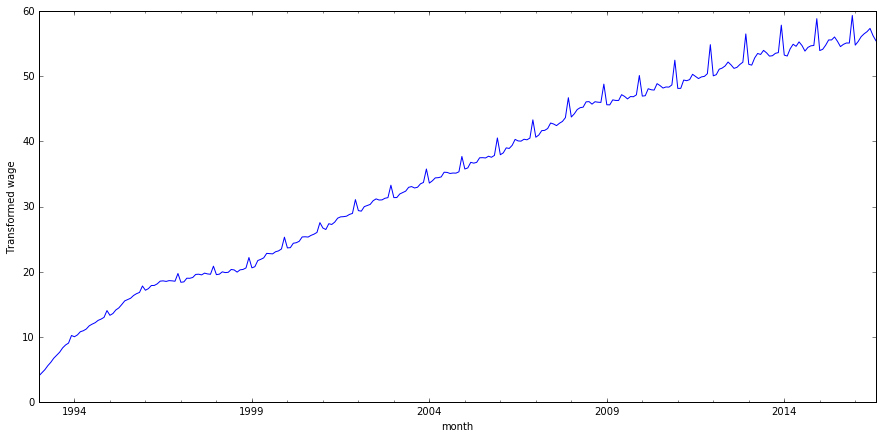

In [8]:
wage['wage_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize = (15, 7))
wage.wage_box.plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

Разложим на составляющие:

# Дифференцирование

Критерий Дики-Фуллера: p=0.696899


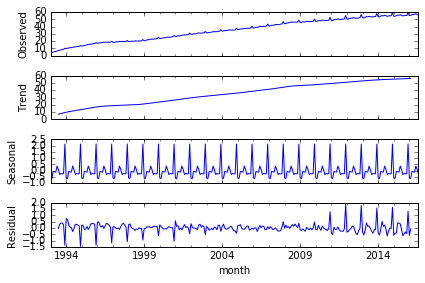

In [9]:
sm.tsa.seasonal_decompose(wage.wage_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

Так как присутствует сильно выраженный тренд, то произведем дифференцирование.
Для начала попробуем дифференцировать на 1 шаг назад и на сезонностьв размере 12 месяцев.

In [10]:
wage['wage_diff1'] = wage['wage_box'] - wage['wage_box'].shift(1)
wage['wage_diff1_s'] = wage['wage_diff1'] - wage['wage_diff1'].shift(12)

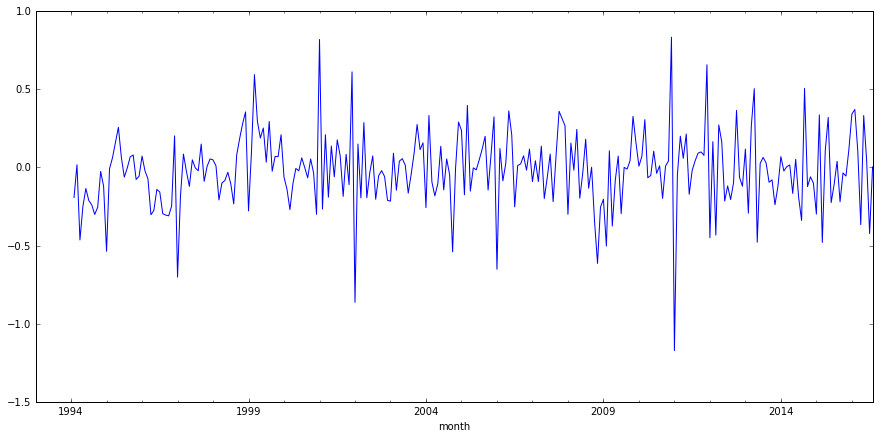

In [11]:
plt.figure(figsize = (15, 7))
wage.wage_diff1_s.plot()

Проведем тест Дики-Фулера для получившегося ряда

In [12]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_diff1_s.dropna(axis = 0, how = 'any'))[1])

Критерий Дики-Фуллера: p=0.000000


Вывод: Дифференцирование на d = 1 и D = 1 делает ряд стационарным.

# Подборначальных значений p, P, q, Q

Построим графики автокорреляционной и частичной автокорреляционной функций:

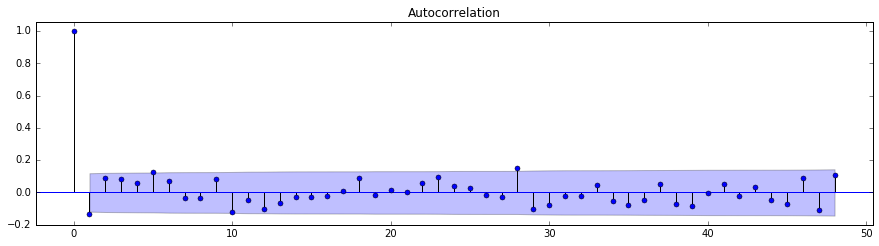

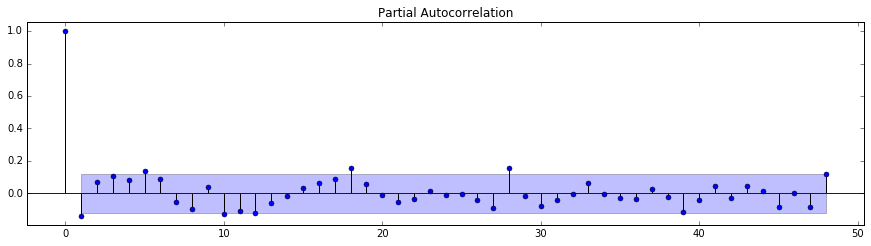

In [13]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_diff1_s[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize = (15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_diff1_s[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=0, q=1, P=0, p=1

In [14]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [15]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

# Выбор модели по критерию Акаике

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 21.2 s


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
29  (3, 1, 1, 0) -4.995860
28  (3, 1, 0, 1) -4.342767
30  (3, 1, 1, 1) -4.312789
37  (4, 1, 1, 0) -3.975974
36  (4, 1, 0, 1) -3.362304


In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Fri, 24 Feb 2017   AIC                             -4.996
Time:                                    17:53:55   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4853      0.210      2.312      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Посмотрим на остатки выбранной модели:

Критерий Стьюдента: p=0.281869
Критерий Дики-Фуллера: p=0.000000


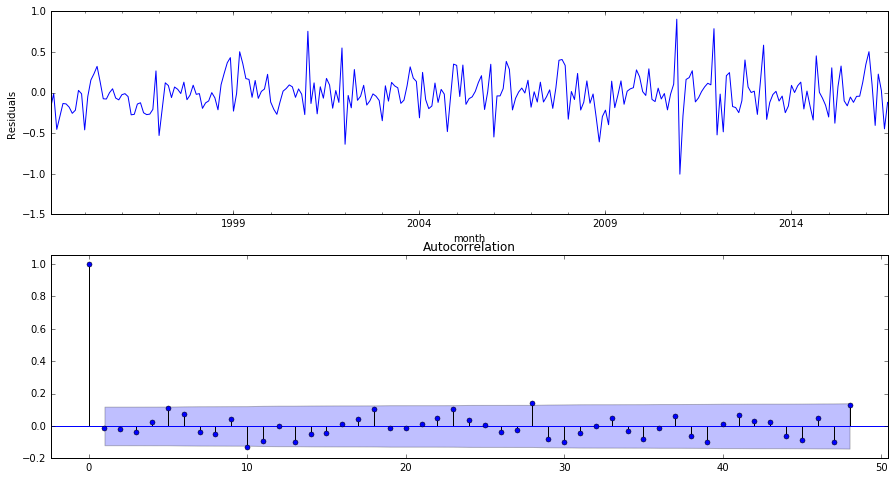

In [19]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

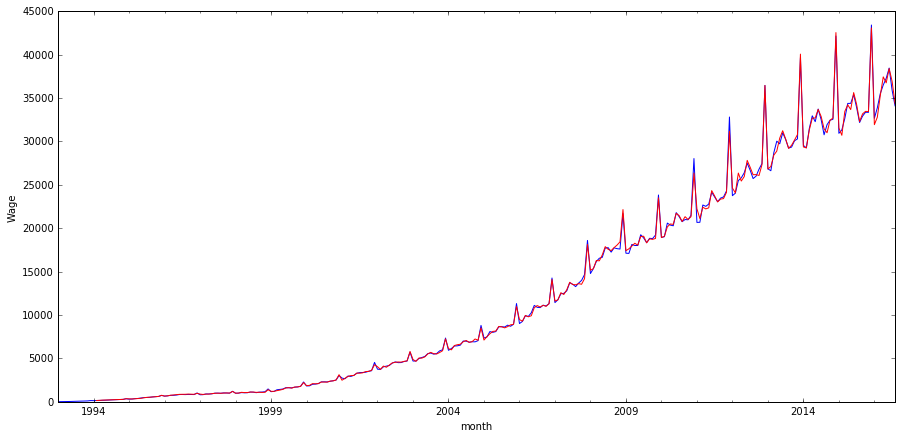

In [22]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,7))
wage['WAG_C_M'].plot()
wage['model'][13:].plot(color='r')
plt.ylabel('Wage')
plt.show()

# Прогноз

In [49]:
import datetime
import dateutil as du

C:\Users\Ilya\Anaconda3\lib\site-packages\dateutil\rrule.py:450: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


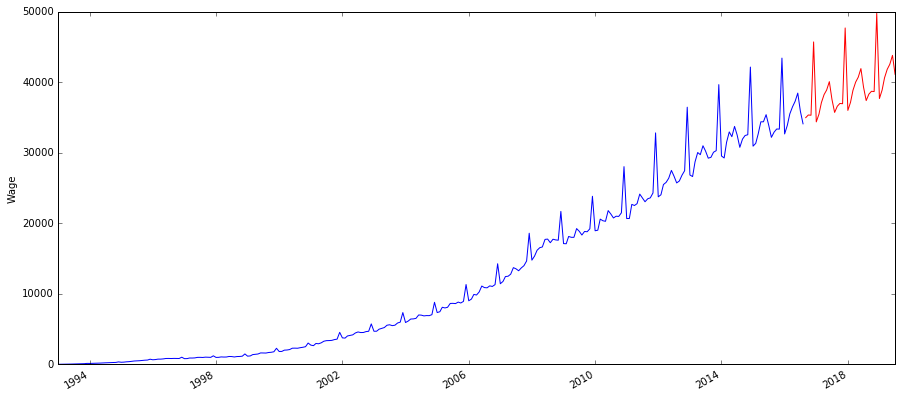

In [54]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + du.relativedelta.relativedelta(months = x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize = (15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
plt.show()